In [1]:
import os
import sys
import subprocess

In [2]:
# We will use PyGuymer3 to set very high-resolution maps from NaturalEarth
# See: https://thomasguymer.co.uk/blog/2018/2018-01-15/
os.environ["CARTOPY_USER_BACKGROUNDS"] = os.path.abspath(".")

if not os.path.isdir("PyGuymer3"):
    subprocess.call("git clone git@github.com:Guymer/PyGuymer3.git", shell=True)

sys.path.append(os.path.abspath("./PyGuymer3/"))

In [3]:
# Define the background image datasets ...
imgs = {
    "cross-blend-hypso" : {
        "description" : "Cross-blended Hypsometric Tints with Relief, Water, Drains and Ocean Bottom from Natural Earth",
        "rasters" : {
            "large"  : "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/HYP_HR_SR_OB_DR.zip",
            "medium" : "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/HYP_LR_SR_OB_DR.zip",
            "small"  : "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/HYP_50M_SR_W.zip",
        },
        "source" : "http://www.naturalearthdata.com/downloads/10m-raster-data/10m-cross-blend-hypso/ and http://www.naturalearthdata.com/downloads/50m-raster-data/50m-cross-blend-hypso/",
    },
    "gray-earth" : {
        "description" : "Gray Earth with Shaded Relief, Hypsography, Ocean Bottom and Drainages from Natural Earth",
        "rasters" : {
            "large"  : "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/GRAY_HR_SR_OB_DR.zip",
            "medium" : "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/GRAY_LR_SR_OB_DR.zip",
            "small"  : "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/GRAY_50M_SR_OB.zip",
        },
        "source" : "http://www.naturalearthdata.com/downloads/10m-raster-data/10m-gray-earth/ and http://www.naturalearthdata.com/downloads/50m-raster-data/50m-gray-earth/",
    },
    "natural-earth-1" : {
        "description" : "Natural Earth I with Shaded Relief, Water and Drainages from Natural Earth",
        "rasters" : {
            "large"  : "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/NE1_HR_LC_SR_W_DR.zip",
            "medium" : "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/NE1_LR_LC_SR_W_DR.zip",
            "small"  : "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/NE1_50M_SR_W.zip",
        },
        "source" : "http://www.naturalearthdata.com/downloads/10m-raster-data/10m-natural-earth-1/ and http://www.naturalearthdata.com/downloads/50m-raster-data/50m-natural-earth-1/",
    },
    "natural-earth-2" : {
        "description" : "Natural Earth II with Shaded Relief, Water and Drainages from Natural Earth",
        "rasters" : {
            "large"  : "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/NE2_HR_LC_SR_W_DR.zip",
            "medium" : "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/NE2_LR_LC_SR_W_DR.zip",
            "small"  : "http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/NE2_50M_SR_W.zip",
        },
        "source" : "http://www.naturalearthdata.com/downloads/10m-raster-data/10m-natural-earth-2/ and http://www.naturalearthdata.com/downloads/50m-raster-data/50m-natural-earth-2/",
    },
    "shaded-relief" : {
        "description" : "Shaded Relief Basic from Natural Earth",
        "rasters" : {
            "large"  : "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/SR_HR.zip",
            "medium" : "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/raster/SR_LR.zip",
            "small"  : "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/SR_50M.zip",
        },
        "source" : "https://www.naturalearthdata.com/downloads/10m-raster-data/10m-shaded-relief/ and https://www.naturalearthdata.com/downloads/50m-raster-data/50m-shaded-relief/",
    },
}

In [4]:
# Import modules ...
import json
import os
import requests
import zipfile

# Import my module ...
try:
    import PyGuymer3
except:
    raise Exception("you need to have the Python module from https://github.com/Guymer/PyGuymer located somewhere in your $PYTHONPATH")

In [5]:
# Create JSON dictionary ...
data = {}
data["__comment__"] = "JSON file specifying the image to use for a given type/name and resolution. Read in by cartopy.mpl.geoaxes.read_user_background_images."

In [6]:
# ******************************************************************************
# *                   CREATE PNG IMAGES FROM REMOTE SOURCES                    *
# ******************************************************************************

# Start session ...
sess = requests.Session()
sess.allow_redirects = True
sess.max_redirects = 5

# Loop over background image datasets ...
for img in imgs.keys():
    # Add to JSON dictionary ...
    data[img] = {}
    data[img]["__comment__"] = imgs[img]["description"]
    data[img]["__projection__"] = "PlateCarree"
    data[img]["__source__"] = imgs[img]["source"]

    # Loop over sizes ...
    # for size in imgs[img]["rasters"].keys():
    for size in ["large"]:
        # Deduce ZIP file name and download it if it is missing ...
        zfile = "{0:s}_{1:s}.zip".format(img, size)
        if not os.path.exists(zfile):
            print("Downloading \"{0:s}\" ...".format(zfile))
            if not PyGuymer3.download_file(sess, imgs[img]["rasters"][size], zfile):
                raise Exception("download failed", imgs[img]["rasters"][size])

        # Deduce TIF file name and extract it if is missing ...
        tfile = "{0:s}_{1:s}.tif".format(img, size)
        if not os.path.exists(tfile):
            print("Extracting \"{0:s}\" ...".format(tfile))
            with zipfile.ZipFile(zfile, "r") as zobj:
                for member in zobj.namelist():
                    if member.lower().endswith(".tif"):
                        tmp = zobj.extract(member)
                        os.rename(tmp, tfile)
                        break

        # Deduce PNG file name and convert TIF to PNG if it is missing ...
        pfile = "{0:s}_{1:s}.png".format(img, size)
        if not os.path.exists(pfile):
            print("Creating \"{0:s}\" ...".format(pfile))
            subprocess.check_call(
                ["convert", tfile, pfile],
                stderr = open(os.devnull, "wt"),
                stdout = open(os.devnull, "wt")
            )
#             subprocess.check_call(
#                 ["optipng", pfile],
#                 stderr = open(os.devnull, "wt"),
#                 stdout = open(os.devnull, "wt")
#             )

        # Add to JSON dictionary ...
        data[img][size] = pfile

# End session ...
sess.close()

In [7]:
# ******************************************************************************
# *              CREATE DOWNSCALED PNG IMAGES FROM LOCAL SOURCES               *
# ******************************************************************************

# Loop over background image datasets ...
for img in imgs.keys():
    # Loop over sizes ...
    # for size in imgs[img]["rasters"].keys():
    for size in ["large"]:
        # Deduce PNG file name ...
        pfile1 = "{0:s}_{1:s}.png".format(img, size)

        # Loop over downscaled sizes ...
        # for width in [512, 1024, 2048, 4096]:
        for width in [4096]:
            # Deduce downscaled PNG file name and create it if missing ...
            pfile2 = "{0:s}_{1:s}{2:04d}px.png".format(img, size, width)
            if not os.path.exists(pfile2):
                print("Creating \"{0:s}\" ...".format(pfile2))
                subprocess.check_call(
                    ["convert", pfile1, "-resize", "{0:d}x".format(width), pfile2],
                    stderr = open(os.devnull, "wt"),
                    stdout = open(os.devnull, "wt")
                )
#                 subprocess.check_call(
#                     ["optipng", pfile2],
#                     stderr = open(os.devnull, "wt"),
#                     stdout = open(os.devnull, "wt")
#                 )

            # Add to JSON dictionary ...
            data[img]["{0:s}{1:04d}px".format(size, width)] = pfile2

In [9]:
# Save JSON dictionary ...
open(
    "images.json",
    "wt",
).write(
    json.dumps(
        data,
        indent = 4,
        sort_keys = True
    )
)

2457

In [10]:
import json
from datetime import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [80]:
with open("Location History.json", "r") as f:
    lh = json.load(f)

In [81]:
# Load all (lat, lon) positions
lats = []
lons = []

# If a (lat, lon) point differs by more than this amount from the previous point, assume
# it's a bad GPS location.
latlon_filter = 999

for point in lh["locations"]:
    lat, lon = int(point["latitudeE7"]) / 1e7, int(point["longitudeE7"]) / 1e7
    
    if len(lats) == 0:
        bad_gps_location = False
    else:
        bad_gps_location = abs(lat - lats[-1]) > latlon_filter or abs(lon - lons[-1]) > latlon_filter
    
    if bad_gps_location:
        continue
    else:
        lats.append(lat)
        lons.append(lon)

print("GPS locations: {}".format(len(lh["locations"])))
print("Good GPS locations: {}".format(len(lats)))

GPS locations: 628996
Good GPS locations: 628996


In [59]:
# Only load (lat, lon) position from May 3-21, 2019
# start_date = datetime(2019, 5, 3)
# end_date = datetime(2019, 5, 21)

# n_days = (end_date - start_date).days
# times = [[] for _ in range(n_days)]
# lats = [[] for _ in range(n_days)]
# lons = [[] for _ in range(n_days)]

# for point in lh["locations"][-60000:-1]:
#     t = datetime.fromtimestamp(int(point["timestampMs"]) / 1000)
#     if start_date <= t <= end_date:
#         lat, lon = int(point["latitudeE7"]) / 1e7, int(point["longitudeE7"]) / 1e7
#         day = (t - start_date).days
#         times[day].append(t)
#         lats[day].append(lat)
#         lons[day].append(lon)

In [60]:
states_provinces = cfeature.NaturalEarthFeature(category="cultural", name="admin_1_states_provinces_lines", scale="10m", facecolor="none")

INFO: Drawing user-requested background.


MemoryError: std::bad_alloc

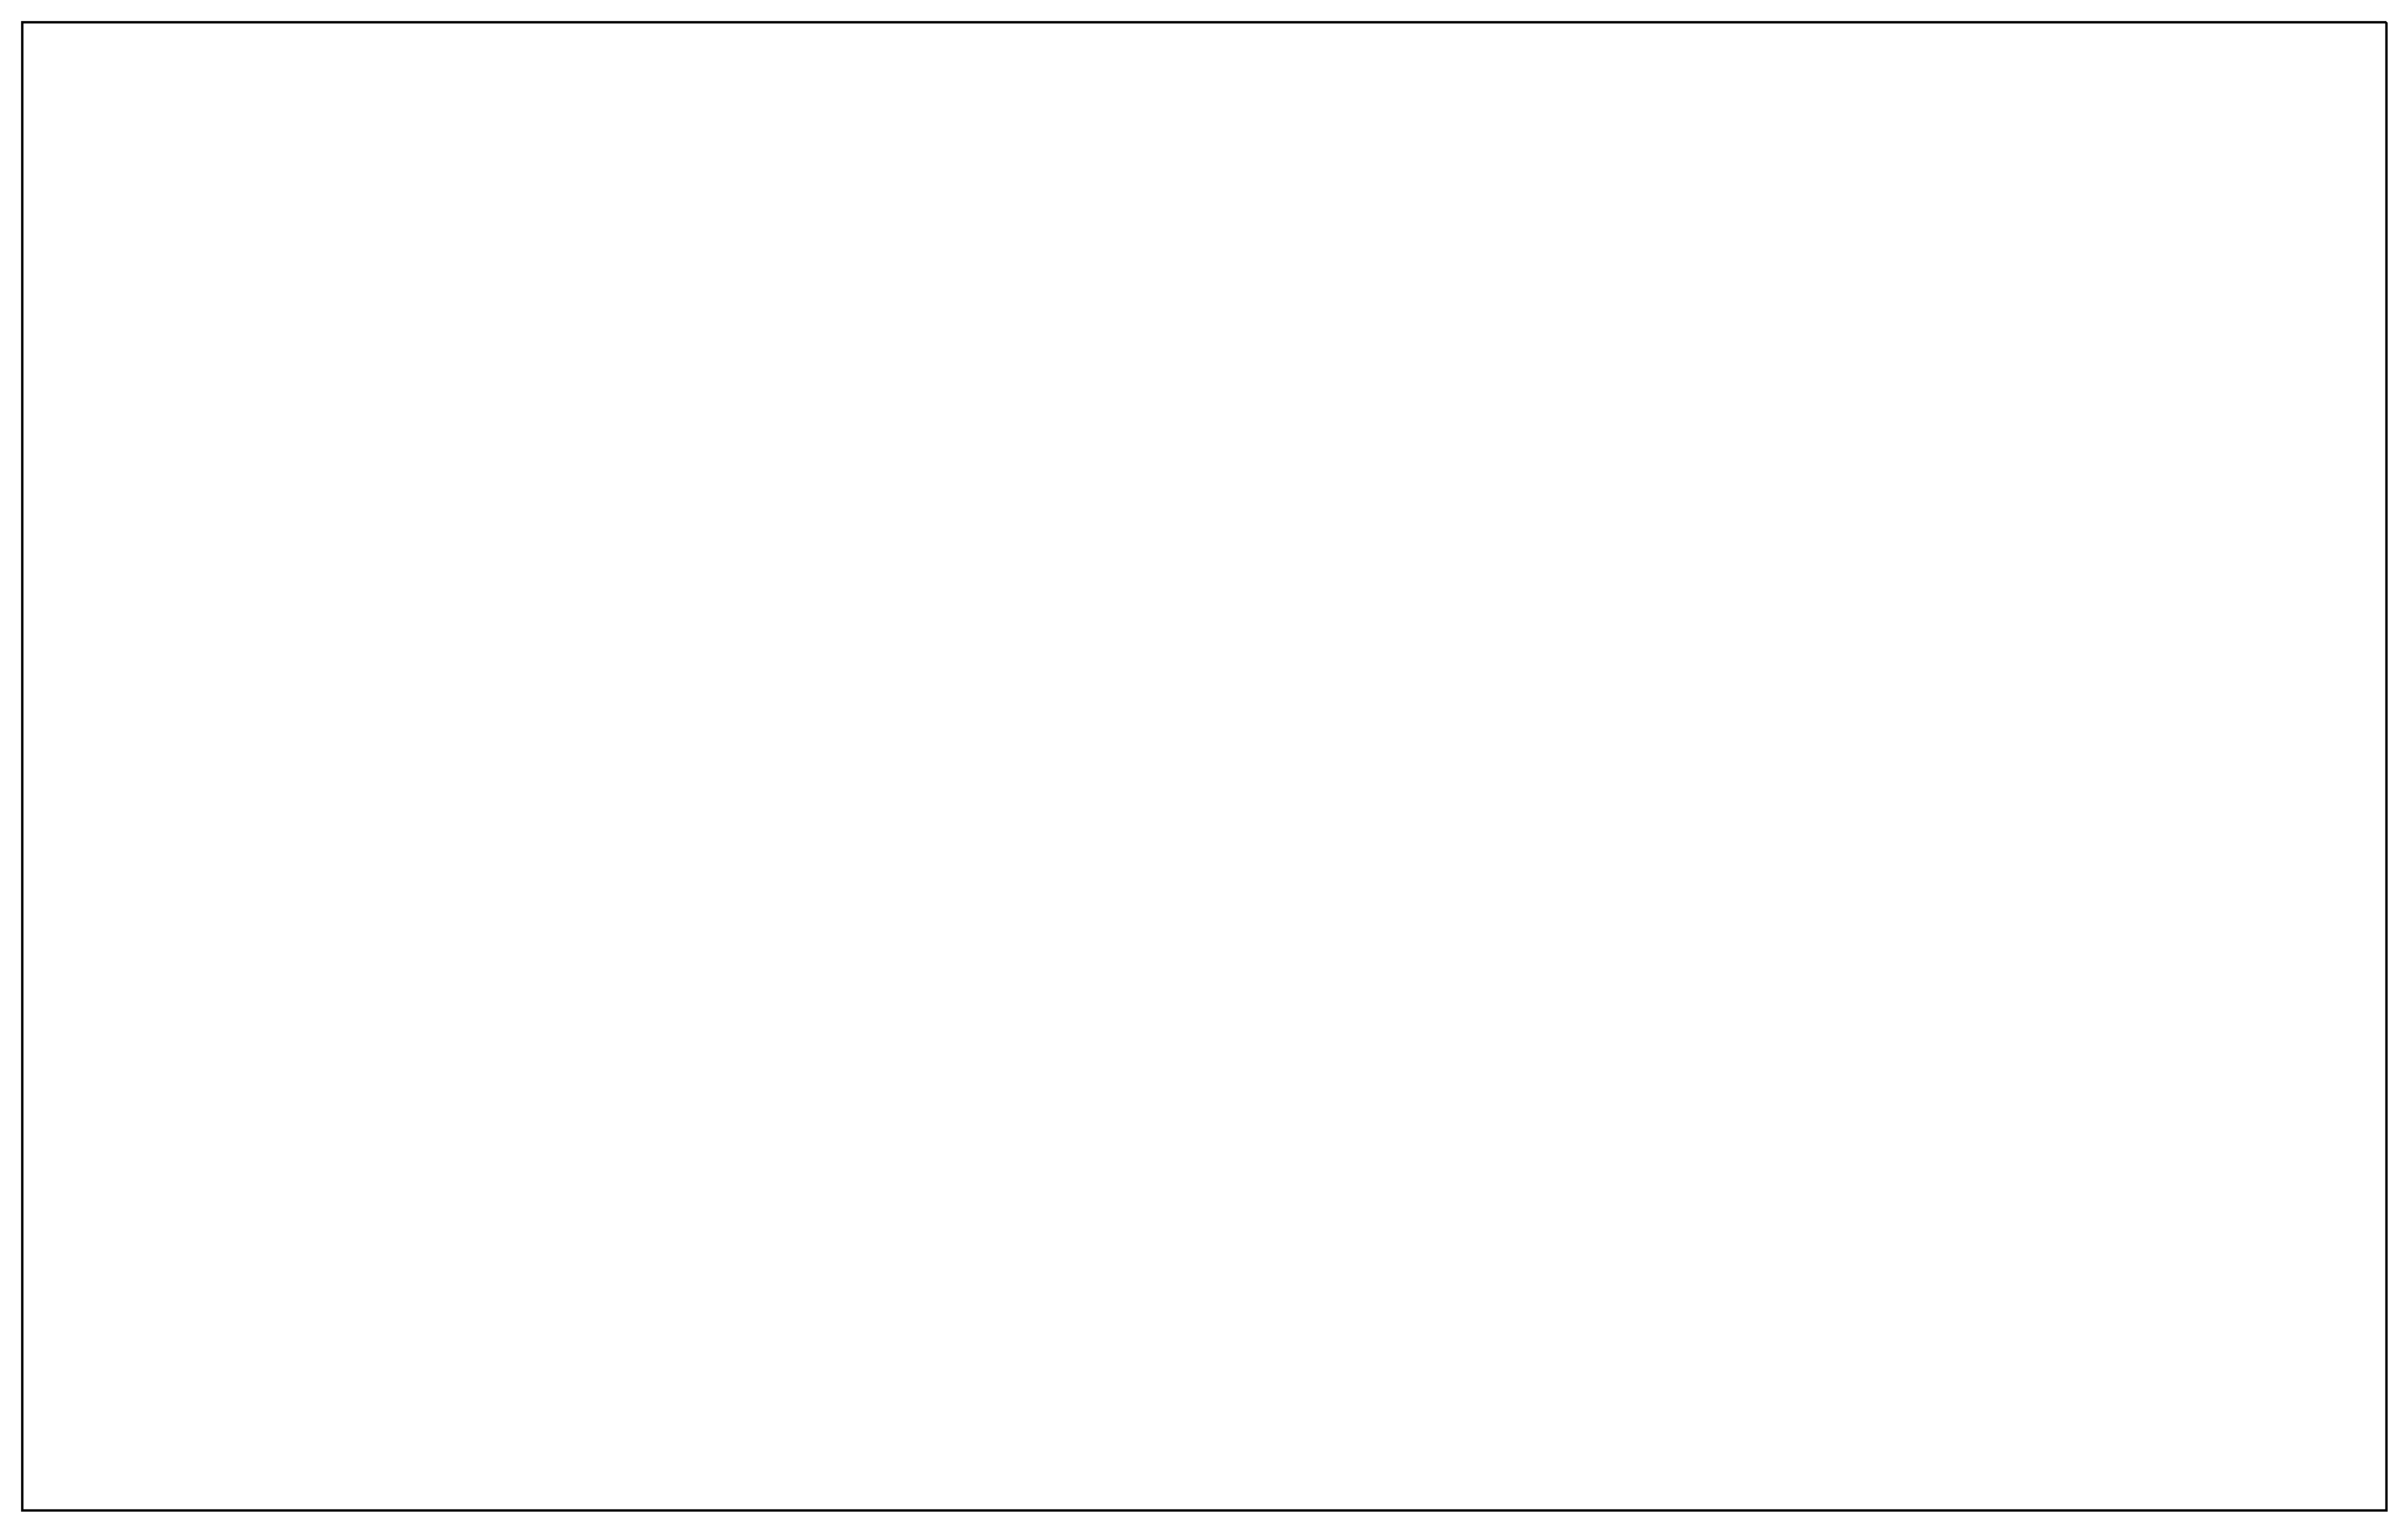

In [89]:
# projection = ccrs.PlateCarree()
projection = ccrs.LambertConformal(central_latitude=25, central_longitude=265, standard_parallels=(25, 25))

fig = plt.figure(figsize=(16, 9), dpi=300)
ax = plt.axes(projection=projection)

lon1, lon2 = 236, 299
lat1, lat2 = 22,  55
ax_extent = [lon1, lon2, lat1, lat2]
bg_extent = [lon1-360, lon2-360, lat1, lat2]

ax.set_extent(ax_extent)

# ax.stock_img()
PyGuymer3.add_map_background(ax, name="natural-earth-1", resolution="large", extent=bg_extent, debug=True)

ax.add_feature(cfeature.BORDERS.with_scale("10m"),   edgecolor="black", linewidth=0.5, alpha=0.8)
ax.add_feature(cfeature.COASTLINE.with_scale("10m"), edgecolor="black", linewidth=0.5, alpha=0.8)
ax.add_feature(cfeature.LAKES.with_scale("10m"),     edgecolor="black", linewidth=0.5, alpha=0.5)
ax.add_feature(cfeature.RIVERS.with_scale("10m"),    edgecolor="black", linewidth=0.5, alpha=0.5)
ax.add_feature(states_provinces,                     edgecolor='black', linewidth=0.5, alpha=0.5)

# ax.plot(lons, lats, linewidth=1, color="red", transform=ccrs.PlateCarree())
ax.scatter(lons, lats, marker=".", c="red", s=0.5, alpha=0.5, transform=ccrs.PlateCarree())

png_filename = "location_history_pretty.png"
print(f"Saving {png_filename}...")
plt.savefig(png_filename, dpi="figure", bbox_inches="tight")

# plt.show()